In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [68]:
dateparse1 = lambda x1: pd.datetime.strptime(x1,"%Y")
data = pd.read_csv('dataset/Europe_Brent_Spot_Price_FOB _Annually.csv',parse_dates=['Date'], date_parser=dateparse1)
data = data.reindex(index=data.index[::-1])
df = data
data.head()
df = df.sort_values('Date')
df = df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
df=df.loc[datetime.date(year=1988,month=1,day=1):]

In [69]:
#dateparse = lambda x: pd.datetime.strptime(x, '%b %d, %Y')
#Read csv file
#df = pd.read_csv('test 1- crude oil/dataset/BrentOilPrices.csv',parse_dates=['Date'], date_parser=dateparse)
#Sort dataset by column Date
#df = df.sort_values('Date')
#df = df.groupby('Date')['Price'].sum().reset_index()
#df.set_index('Date', inplace=True)
#df=df.loc[datetime.date(year=2000,month=1,day=1):]

In [70]:
def DfInfo(df_initial):
    # gives some infos on columns types and numer of null values
    tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.
                               rename(index={0: 'null values (%)'}))
    return tab_info

In [71]:
df.head()

,Price
Date,
1988-01-01,14.91
1989-01-01,18.23
1990-01-01,23.76
1991-01-01,20.04
1992-01-01,19.32


In [72]:
DfInfo(df)

,Price
column type,float64
null values (nb),0
null values (%),0.0


In [73]:
df.index

DatetimeIndex(['1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

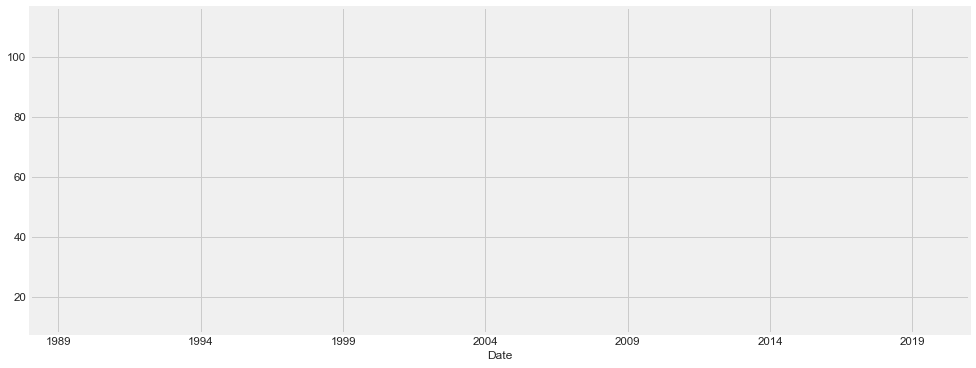

In [74]:
y = df['Price'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

In [75]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()


ValueError: This function does not handle missing values

In [76]:
print(df)
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)
df

             Price
Date              
1988-01-01   14.91
1989-01-01   18.23
1990-01-01   23.76
1991-01-01   20.04
1992-01-01   19.32
1993-01-01   17.01
1994-01-01   15.86
1995-01-01   17.02
1996-01-01   20.64
1997-01-01   19.11
1998-01-01   12.76
1999-01-01   17.90
2000-01-01   28.66
2001-01-01   24.46
2002-01-01   24.99
2003-01-01   28.85
2004-01-01   38.26
2005-01-01   54.57
2006-01-01   65.16
2007-01-01   72.44
2008-01-01   96.94
2009-01-01   61.74
2010-01-01   79.61
2011-01-01  111.26
2012-01-01  111.63
2013-01-01  108.56
2014-01-01   98.97
2015-01-01   52.32
2016-01-01   43.64
2017-01-01   54.13
2018-01-01   71.34
2019-01-01   64.30
2020-01-01   41.96
2021-01-01   70.86


array([[0.02174573],
       [0.05532517],
       [0.11125721],
       [0.07363204],
       [0.06634975],
       [0.04298574],
       [0.0313543 ],
       [0.04308688],
       [0.07970062],
       [0.06422575],
       [0.        ],
       [0.05198746],
       [0.16081723],
       [0.11833721],
       [0.12369778],
       [0.16273895],
       [0.25791443],
       [0.42287853],
       [0.52998887],
       [0.60362092],
       [0.85142106],
       [0.495398  ],
       [0.67614039],
       [0.99625771],
       [1.        ],
       [0.96894913],
       [0.87195307],
       [0.40012137],
       [0.31232932],
       [0.41842824],
       [0.5924952 ],
       [0.52129058],
       [0.29533731],
       [0.58764034]])

In [77]:
# split into train and test sets
train_size = int(len(df) * 0.70)
test_size = int((len(df) - train_size)/2)
val_size = test_size
train, val, test = df[0:train_size, :],df[train_size:train_size+val_size, : ], df[train_size+val_size:len(df), :]
print(train,"\n****************************\n")
print(test,"\n****************************\n")

[[0.02174573]
 [0.05532517]
 [0.11125721]
 [0.07363204]
 [0.06634975]
 [0.04298574]
 [0.0313543 ]
 [0.04308688]
 [0.07970062]
 [0.06422575]
 [0.        ]
 [0.05198746]
 [0.16081723]
 [0.11833721]
 [0.12369778]
 [0.16273895]
 [0.25791443]
 [0.42287853]
 [0.52998887]
 [0.60362092]
 [0.85142106]
 [0.495398  ]
 [0.67614039]] 
****************************

[[0.31232932]
 [0.41842824]
 [0.5924952 ]
 [0.52129058]
 [0.29533731]
 [0.58764034]] 
****************************



In [78]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        print(a)
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)


In [80]:
# reshape into X=t and Y=t+1
look_back =3
X_train,Y_train,X_test,Ytest,Y_val,Y_val = [],[],[],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_val,Y_val=create_data_set(val,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


[0.02174573 0.05532517 0.11125721]
[0.05532517 0.11125721 0.07363204]
[0.11125721 0.07363204 0.06634975]
[0.07363204 0.06634975 0.04298574]
[0.06634975 0.04298574 0.0313543 ]
[0.04298574 0.0313543  0.04308688]
[0.0313543  0.04308688 0.07970062]
[0.04308688 0.07970062 0.06422575]
[0.07970062 0.06422575 0.        ]
[0.06422575 0.         0.05198746]
[0.         0.05198746 0.16081723]
[0.05198746 0.16081723 0.11833721]
[0.16081723 0.11833721 0.12369778]
[0.11833721 0.12369778 0.16273895]
[0.12369778 0.16273895 0.25791443]
[0.16273895 0.25791443 0.42287853]
[0.25791443 0.42287853 0.52998887]
[0.42287853 0.52998887 0.60362092]
[0.52998887 0.60362092 0.85142106]
[0.99625771 1.         0.96894913]
[0.31232932 0.41842824 0.5924952 ]
[0.41842824 0.5924952  0.52129058]


In [81]:
# create and fit the LSTM network regressor = Sequential() 
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_val, Y_val), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
2/2 [==============================] - 5s 1s/step - loss: 0.1009 - val_loss: 0.7173 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 0s 30ms/step - loss: 0.0940 - val_loss: 0.6788 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 0s 26ms/step - loss: 0.0868 - val_loss: 0.6369 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 0s 25ms/step - loss: 0.0808 - val_loss: 0.5909 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 0s 26ms/step - loss: 0.0736 - val_loss: 0.5401 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 0s 26ms/step - loss: 0.0660 - val_loss: 0.4837 - lr: 0.0010
Epoch 7/20
2/2 [==============================] - 0s 24ms/step - loss: 0.0580 - val_loss: 0.4218 - lr: 0.0010
Epoch 8/20
2/2 [==============================] - 0s 25ms/step - loss: 0.0524 - val_loss: 0.3549 - lr: 0.0010
Epoch 9/20
2/2 [==============================] - 0s 25ms/step - loss: 0.0478 - val_loss: 0.2844 - lr: 0.0010
Epoch 10/20


In [82]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [83]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Train Mean Absolute Error: 22.134389487818666
Train Root Mean Squared Error: 23.66639320527526
Test Mean Absolute Error: 13.94405548095703
Test Root Mean Squared Error: 17.979156840481746


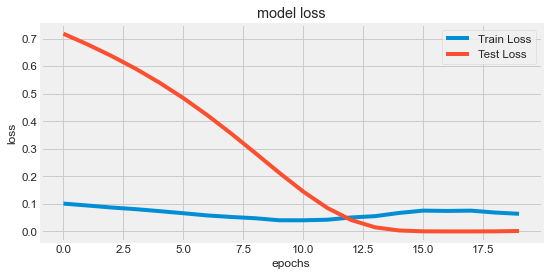

In [84]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

[61.705544]


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

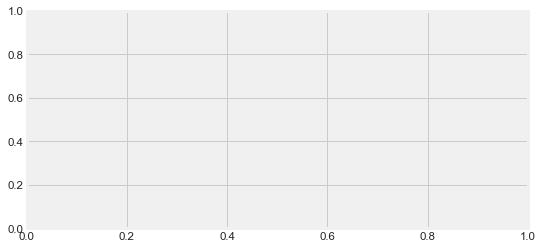

In [88]:
#Compare Actual vs. Prediction

print(test_predict[:,0][:1])

aa=[x for x in range(0,1)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:2], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:2], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();